In [1]:
%matplotlib inline
from skimage import io
from skimage.transform import resize, pyramid_gaussian
import numpy as np
import random
from sklearn import svm
from skimage.feature import hog
from sklearn.naive_bayes import GaussianNB
import os
from sklearn.externals import joblib
import time
from collections import defaultdict

In [6]:
class GestureRecognizer(object):

    """class to perform gesture recognition"""

    def __init__(self, data_directory):

        """
            data_directory : path like /home/sanket/mlproj/dataset/
            includes the dataset folder with '/'

            Initialize all your variables here
        """
        self.base_dir = data_directory
        # self.base_dir = os.path.abspath('.') + '/dataset/'
        self.win_size = 128
        self.clf_gesture = None
        self.clf_hnh = None

    def IOU(self,boxA, boxB):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])

        # compute the area of intersection rectangle
        interArea = (xB - xA + 1) * (yB - yA + 1)

        # compute the area of both the prediction and ground-truth
        # rectangles
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

        iou = interArea / float(boxAArea + boxBArea - interArea)

        # return the intersection over union value
        return iou
    
    
    def train(self, train_list):

        """
            train_list : list of users to use for training
            eg ["user_1", "user_2", "user_3"]

            The train function should train all your classifiers,
            both binary and multiclass on the given list of users
        """
        
        train_x_pos_ = []
        train_x_neg_ = []
        train_y = []
        
        for user in train_list:
            csv_file = self.base_dir + user + '/' + user + '_loc.csv'
            with open(csv_file,'r') as f:
                f.readline()
                for line in f:
                    data = line.strip().split(',')
                    file_name = data[0]
                    x1,y1,x2,y2 = map(int, data[1:])
                    
                    img = io.imread(self.base_dir + file_name,as_grey=True)
                    h,w = img.shape[:2]
                    imgg = img[y1:y2,x1:x2]
                    imgg = resize(imgg, (self.win_size, self.win_size))
                    imgg_hog = hog(imgg)
                    
                    label = ord(file_name.split('/')[1][0])
                    
                    train_x_pos_.append(imgg_hog)
                    train_y.append(label)
                    
                    count = 0
                    
                    A = [x1,y1,x2,y2]
                    
                    while True:
                        x1_r = random.randrange(0,w - self.win_size)
                        y1_r = random.randrange(0,h - self.win_size)
                        x2_r = x1_r + self.win_size
                        y2_r = y1_r + self.win_size
                        
                        if y2_r >= h or x2_r>=w:
                            continue
                        
                        B = [x1_r, y1_r, x2_r, y2_r]
                        
                        if self.IOU(A,B) <= 0.5:
                            train_x_neg_.append(hog(img[y1_r:y2_r,x1_r:x2_r]))
                            count += 1
                        
                        if count >= 2:
                            break
        
        self.train_x_pos = np.asarray(train_x_pos_)
        del train_x_pos_
        self.train_x_neg = np.asarray(train_x_neg_)
        del train_x_neg_
        train_y = np.asarray(train_y)
        
        self.clf_gesture =  svm.LinearSVC()
        self.clf_gesture.fit(self.train_x_pos, train_y)
        score_gesture = self.clf_gesture.score(self.train_x_pos, train_y)
        print 'Training accuracy for gesture classifier : %f' %(score_gesture)
        
        # self.clf_hnh = svm.LinearSVC()
        self.clf_hnh = GaussianNB()
        train_x_hnh = np.concatenate((self.train_x_pos , self.train_x_neg))
        train_y_hnh = np.asarray( [1] * len(self.train_x_pos) + [0] * len(self.train_x_neg))
        self.clf_hnh.partial_fit(train_x_hnh, train_y_hnh, classes = np.asarray([1,0]))
        score_hnh = self.clf_hnh.score(train_x_hnh, train_y_hnh)
        print 'Training accuracy for Hand/Non-hand classifier : %f' %(score_hnh)
    
    
    def test(self, test_list):

        """
            train_list : list of users to use for training
            eg ["user_1", "user_2", "user_3"]

            The train function should train all your classifiers,
            both binary and multiclass on the given list of users
        """
        
        if self.clf_hnh is None or self.clf_gesture is None:
            print 'Classifiers not trained'
            return
        
        test_x_pos = []
        test_x_neg = []
        test_y = []
        
        for user in test_list:
            csv_file = self.base_dir + user + '/' + user + '_loc.csv'
            with open(csv_file,'r') as f:
                f.readline()
                for line in f:
                    data = line.strip().split(',')
                    file_name = data[0]
                    x1,y1,x2,y2 = map(int, data[1:])
                    
                    img = io.imread(self.base_dir + file_name,as_grey=True)
                    h,w = img.shape[:2]
                    imgg = img[y1:y2,x1:x2]
                    imgg = resize(imgg, (self.win_size, self.win_size))
                    imgg_hog = hog(imgg)
                    
                    label = ord(file_name.split('/')[1][0])
                    
                    test_x_pos.append(imgg_hog)
                    test_y.append(label)
                    
                    count = 0
                    
                    A = [x1,y1,x2,y2]
                    
                    while True:
                        x1_r = random.randrange(0,w - self.win_size)
                        y1_r = random.randrange(0,h - self.win_size)
                        x2_r = x1_r + self.win_size
                        y2_r = y1_r + self.win_size
                        
                        if y2_r >= h or x2_r>=w:
                            continue
                        
                        B = [x1_r, y1_r, x2_r, y2_r]
                        
                        if self.IOU(A,B) <= 0.5:
                            test_x_neg.append(hog(img[y1_r:y2_r,x1_r:x2_r]))
                            count += 1
                        
                        if count >= 2:
                            break
        
        
        test_x_pos = np.asarray(test_x_pos)
        test_x_neg = np.asarray(test_x_neg)
        test_y = np.asarray(test_y)
        
        score_gesture = self.clf_gesture.score(test_x_pos, test_y)
        print 'Testing accuracy for gesture classifier : %f' %(score_gesture)
        
        
        test_x_hnh = np.concatenate((test_x_pos, test_x_neg))
        test_y_hnh = np.asarray( [1] * len(test_x_pos) + [0] * len(test_x_neg) )
        
        score_hnh = self.clf_hnh.score(test_x_hnh,test_y_hnh)
        print 'Testing accuracy for Hand/Non-hand classifier : %f' %(score_hnh)

    
    def hard_negative_mining(self, no_iter, threshold):
        
        if self.clf_hnh is None or self.clf_gesture is None:
            print 'Classifiers not trained'
            return
        
        for i in xrange(no_iter):
            count = 0
            FP = []
            
            for data in self.train_x_neg:
                if self.clf_hnh.predict([data])[0] == 1:
                    count+=1
                    FP.append(data)
            
            if i%10==0:
                print i, count
                
            if count <= threshold:
                break
            
            self.clf_hnh.partial_fit(np.asarray(FP), np.asarray([0] * len(FP)))
        
        Y = np.asarray([1] * self.train_x_pos.shape[0] +  [0] * self.train_x_neg.shape[0])
        score_ = self.clf_hnh.score(np.concatenate((self.train_x_pos, self.train_x_neg)), Y)
        print 'Accuracy for Hand/Non-hand classifier after Hard Negative Mining : %f' %(score_)
        
    def sliding_window(self, img):
        # conf_map = np.zeros(img.shape)
        
        h,w = img.shape[:2]
        stride = 10
        win_size = self.win_size
        
        bbox = defaultdict(list)
        
        # Y is for rows and X is for the column
        
        print 'Dimension test : ', (h-win_size > 10)  
        
        for row in xrange(0,h-win_size+1,stride):
            for col in xrange(0,w-win_size+1,stride):
                imgg = img[row:row+win_size, col:col+win_size]
                hog_ = hog(imgg)
                
                # 1th index is giving the prob. of the class 'hand'
                class_ = self.clf_hnh.predict_proba(np.asarray([hog_]))[0][1]
                
                if class_ > 0.7:
                    bbox[class_].append([row, col, row + win_size, col + win_size])
        
        return bbox[max(bbox.keys())]
    
    def non_maximal_supression(self, boxes, overlapThresh):
        if len(boxes) == 0:
            return []
        
        pick = []
        x1 = boxes[:,0]
        y1 = boxes[:,1]
        x2 = boxes[:,2]
        y2 = boxes[:,3]
    
        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        idxs = np.argsort(y2)
    
        while len(idxs) > 0:
            last = len(idxs) - 1
            i = idxs[last]
            pick.append(i)
            suppress = [last]
            for pos in xrange(0, last):
                j = idxs[pos]
                xx1 = max(x1[i], x1[j])
                yy1 = max(y1[i], y1[j])
                xx2 = min(x2[i], x2[j])
                yy2 = min(y2[i], y2[j])
            
                w = max(0, xx2 - xx1 + 1)
                h = max(0, yy2 - yy1 + 1)
            
                overlap = float(w * h) / area[j]
            
                if overlap > overlapThresh:
                    suppress.append(pos)
            
            idxs = np.delete(idxs, suppress)

        return boxes[pick]
    
    
    def get_bbox(self, image):
        
        if self.clf_hnh is None or self.clf_gesture is None:
            print 'Classifiers not trained'
            return
        
        downscale_ = 1.2
        py = pyramid_gaussian(image, downscale = downscale_)
        py_img  = [py.next(), py.next(), py.next()]
        
        bbox = []
        
        for i in xrange(len(py_img)):
            boxes = self.sliding_window(py_img[i])
            factor = downscale_**i
            scale_box = lambda x : int(x*factor)
            boxes = map(lambda x : map(scale_box, x), boxes)
            bbox += boxes
            
        pos = self.non_maximal_supression(np.asarray(bbox), 0.7)
        
        print 'pos len', len(pos)
        
        return pos[0]
        
    def recognize_gesture(self, image):

        """
            image : a 320x240 pixel RGB image in the form of a numpy array
            
            This function should locate the hand and classify the gesture.

            returns : (position, label)

            position : a tuple of (x1,y1,x2,y2) coordinates of bounding box
                       x1,y1 is top left corner, x2,y2 is bottom right

            label : a single character. eg 'A' or 'B'
        """
        try:
            position = self.get_bbox(image)
            imgg = image[position[0]:position[2], position[1] : position[3]]
            imgg = resize(imgg, (self.win_size, self.win_size))
            label = chr(self.clf_gesture.predict(np.asarray( [hog(imgg)]))[0])
            print 'POS : ', position, 'label : ', label
            return position, label
        except Exception as e:
            print e

    def translate_video(self, image_array):

        """
            image_array : a list of images as described above.
                          can be of arbitrary length

            This function classifies the video into a 5 character string

            returns : word (a string of 5 characters)
                    no two consecutive characters are identical
        """

        return word
    
    def test_labelled_images(self):
        
        if self.clf_hnh is None or self.clf_gesture is None:
            print 'Classifiers not trained'
            return

        # test_list = [3,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19]
        test_list = [3,4,5,6,7]
        test_list = map(lambda x : 'user_' + str(x), test_list)
        
        count = 0
        total = 0
        for user in test_list:
            no_user = 0
            IOU_val = 0.0
            print user
            
            csv_file = self.base_dir + user + '/' + user + '_loc.csv'
            with open(csv_file,'r') as f:
                f.readline()
                for line in f:
                    data = line.strip().split(',')
                    file_name = data[0]
                    x1,y1,x2,y2 = map(int, data[1:])
                    
                    img = io.imread(self.base_dir + file_name,as_grey=True)
                    total+=1
                    h,w = img.shape[:2]
                    label = file_name.split('/')[1][0]
                    
                    pos, label_ = self.recognize_gesture(img)
                    
                    IOU_val += self.IOU([x1,y1,x2,y2],pos)
                    no_user += 1
                    
                    if label == label_:
                        count+=1
            
            print user, 'IOU : ',IOU_val/no_user
        
        score_gesture = (count*1.0)/(total*1.0)
        print 'Testing accuracy for gesture classifier class : %f' %(score_gesture)
        
    def store_clfs(self):
        label = time.ctime().split()[3]
        path = self.base_dir + 'clf_models/' + label
        joblib.dump(self.clf_hnh, path + '_hnh.pkl')
        joblib.dump(self.clf_gesture, path + '_gesture.pkl')
    
    def load_clfs(self, label):
        path = self.base_dir + 'clf_models/' + label
        self.clf_hnh = joblib.load(path + '_hnh.pkl')
        self.clf_gesture = joblib.load(path + '_gesture.pkl')
    

In [7]:
G = GestureRecognizer(os.path.abspath('.') + '/dataset/')
print G.base_dir

/home/ayush/GPU_ML/ML/workspace/project/complete_data/dataset/


In [8]:
G.load_clfs('06:18:36')

Dimension test :  True
Dimension test :  True
Dimension test :  True
pos len 1
POS :  [  0 129 184 313] label :  B


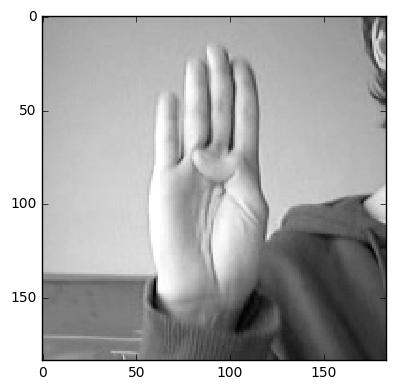

In [11]:
img = io.imread('/home/ayush/GPU_ML/ML/workspace/project/complete_data/dataset/user_3/B0.jpg', as_grey=True)
# print img.shape
pos, label = G.recognize_gesture(img)
# print pos, label
io.imshow(img[pos[0]:pos[2],pos[1]:pos[3]])

In [72]:
G.clf_hnh.predict_proba([hog(resize(img[139:289,12:162], (128,128)))])[0]

array([  3.21775349e-150,   1.00000000e+000])

In [16]:
G.clf_hnh.classes_
G.IOU(pos, [12,139,162,289])

0.6662089116143171

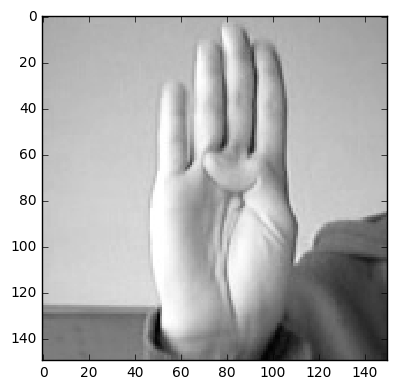

In [15]:
io.imshow(img[12:162,139:289])

In [4]:
user = [3,4,5,6,7,9,10,11,12,13,14,15]
user = map(lambda x : 'user_' + str(x), user)
print user

user_test = [16,17,18,19]
user_test = map(lambda x : 'user_' + str(x), user_test)
print user_test

['user_3', 'user_4', 'user_5', 'user_6', 'user_7', 'user_9', 'user_10', 'user_11', 'user_12', 'user_13', 'user_14', 'user_15']
['user_16', 'user_17', 'user_18', 'user_19']


In [5]:
G.train(user)

Training accuracy for gesture classifier : 1.000000
Training accuracy for Hand/Non-hand classifier : 0.941551


In [6]:
G.hard_negative_mining(100,5)

0 410
10 105
20 66
30 35
40 25
50 18
60 11
70 6
Accuracy for Hand/Non-hand classifier after Hard Negative Mining : 0.977199


In [7]:
G.test(user_test)

Testing accuracy for gesture classifier : 0.764583
Testing accuracy for Hand/Non-hand classifier : 0.951736


In [8]:
G.store_clfs()

In [ ]:
io.imshow(img[,])

In [8]:
G.test_labelled_images()

user_3
index 2 is out of bounds for axis 0 with size 1


TypeError: 'NoneType' object is not iterable

In [12]:
del G